# Expanded Hubbard: Exact vs VQE

Standalone notebook that uses only Qiskit/Qiskit Nature built-ins to:
1. Build 1D Fermi-Hubbard models for `L=2` and `L=3`.
2. Map with Jordan-Wigner.
3. Solve with VQE + UCCSD.
4. Compare against exact energies in the same particle-number sector.
5. Plot exact vs VQE energies as a bar chart.


In [19]:
import sys
print(sys.executable)
print(sys.version)




/opt/anaconda3/bin/python
3.10.12 (main, Jul  5 2023, 15:02:25) [Clang 14.0.6 ]


In [20]:
from __future__ import annotations

import os
import sys

os.environ.setdefault('MPLCONFIGDIR', '/tmp/matplotlib')
os.makedirs(os.environ['MPLCONFIGDIR'], exist_ok=True)

try:
    import qiskit
    import qiskit_nature
except Exception as exc:
    raise RuntimeError('qiskit and qiskit_nature are required in this kernel.') from exc

try:
    from qiskit_algorithms.minimum_eigensolvers import NumPyMinimumEigensolver, VQE
    from qiskit_algorithms.optimizers import SLSQP
except Exception:
    try:
        from qiskit.algorithms.minimum_eigensolvers import NumPyMinimumEigensolver, VQE
        from qiskit.algorithms.optimizers import SLSQP
    except Exception as exc:
        raise RuntimeError('Need qiskit_algorithms (or compatible qiskit.algorithms) in this kernel.') from exc

try:
    from qiskit.primitives import StatevectorEstimator
except Exception as exc:
    raise RuntimeError('This notebook expects qiskit.primitives.StatevectorEstimator.') from exc

try:
    from qiskit_nature.second_q.circuit.library import HartreeFock, UCCSD
    from qiskit_nature.second_q.hamiltonians import FermiHubbardModel
    from qiskit_nature.second_q.hamiltonians.lattices import BoundaryCondition, LineLattice
    from qiskit_nature.second_q.mappers import JordanWignerMapper
    from qiskit_nature.second_q.operators import FermionicOp
except Exception as exc:
    raise RuntimeError('This notebook expects qiskit_nature second_q modules (>=0.5 style API).') from exc

import numpy as np
import matplotlib
if 'ipykernel' not in sys.modules:
    matplotlib.use('Agg')
import matplotlib.pyplot as plt

print('qiskit:', qiskit.__version__)
print('qiskit_nature:', qiskit_nature.__version__)


qiskit: 2.3.0
qiskit_nature: 0.7.2


In [21]:
MODEL_CONFIG = {
    'lattice_sizes': [2, 3],
    'hopping_t': 1.0,
    'onsite_u': 4.0,
    'boundary_condition': 'periodic',
    'filling': 'half',
    'spin_orbital_ordering': 'blocked',
}

VQE_CONFIG = {
    'mapper': 'JordanWignerMapper',
    'ansatz': 'UCCSD',
    'ansatz_reps': 2,
    'initial_state': 'HartreeFock',
    'optimizer': 'SLSQP',
    'maxiter': 1200,
    'restarts': 2,
    'seed': 7,
    'initial_point_stddev': 0.3,
    'estimator': 'StatevectorEstimator',
}

print('Model configuration:')
for k, v in MODEL_CONFIG.items():
    print(f'  {k}: {v}')
print('\nVQE configuration:')
for k, v in VQE_CONFIG.items():
    print(f'  {k}: {v}')


Model configuration:
  lattice_sizes: [2, 3]
  hopping_t: 1.0
  onsite_u: 4.0
  boundary_condition: periodic
  filling: half

VQE configuration:
  mapper: JordanWignerMapper
  ansatz: UCCSD
  ansatz_reps: 2
  initial_state: HartreeFock
  optimizer: SLSQP
  maxiter: 1200
  restarts: 2
  seed: 7
  initial_point_stddev: 0.3
  estimator: StatevectorEstimator


In [22]:
def interleaved_to_blocked_permutation(num_sites):
    # Convert (a1,b1,a2,b2,...) -> (a1,a2,...,b1,b2,...) ordering
    return [idx for site in range(num_sites) for idx in (site, num_sites + site)]


def apply_spin_orbital_ordering(fermionic_op, num_sites, spin_orbital_ordering='blocked'):
    ordering = str(spin_orbital_ordering).strip().lower()
    if ordering == 'blocked':
        return fermionic_op.permute_indices(interleaved_to_blocked_permutation(num_sites))
    if ordering == 'interleaved':
        return fermionic_op
    raise ValueError(
        "spin_orbital_ordering must be 'blocked' or 'interleaved'; got {}".format(spin_orbital_ordering)
    )


def half_filled_particles(num_sites):
    return ((num_sites + 1) // 2, num_sites // 2)


def build_qubit_hamiltonian(num_sites, t, u, mapper, spin_orbital_ordering='blocked'):
    lattice = LineLattice(
        num_nodes=num_sites,
        edge_parameter=-t,
        onsite_parameter=0.0,
        boundary_condition=BoundaryCondition.PERIODIC,
    )
    fermionic_op = FermiHubbardModel(lattice=lattice, onsite_interaction=u).second_q_op()
    fermionic_op = apply_spin_orbital_ordering(
        fermionic_op, num_sites, spin_orbital_ordering=spin_orbital_ordering
    )
    return mapper.map(fermionic_op)


def spin_orbital_index_sets(num_sites, spin_orbital_ordering='blocked'):
    ordering = str(spin_orbital_ordering).strip().lower()
    if ordering == 'blocked':
        return list(range(num_sites)), list(range(num_sites, 2 * num_sites))
    if ordering == 'interleaved':
        return list(range(0, 2 * num_sites, 2)), list(range(1, 2 * num_sites, 2))
    raise ValueError(
        "spin_orbital_ordering must be 'blocked' or 'interleaved'; got {}".format(spin_orbital_ordering)
    )


def build_number_aux_ops(num_sites, mapper, spin_orbital_ordering='blocked'):
    n_spin_orbitals = 2 * num_sites
    alpha_indices, beta_indices = spin_orbital_index_sets(
        num_sites, spin_orbital_ordering=spin_orbital_ordering
    )
    n_alpha = FermionicOp(
        {f'+_{i} -_{i}': 1.0 for i in alpha_indices},
        num_spin_orbitals=n_spin_orbitals,
    )
    n_beta = FermionicOp(
        {f'+_{i} -_{i}': 1.0 for i in beta_indices},
        num_spin_orbitals=n_spin_orbitals,
    )
    return {'N_alpha': mapper.map(n_alpha), 'N_beta': mapper.map(n_beta)}


def filtered_exact_energy(qubit_hamiltonian, num_particles, aux_ops):
    def criterion(_state, _energy, aux_values):
        n_alpha = float(np.real(aux_values['N_alpha'][0]))
        n_beta = float(np.real(aux_values['N_beta'][0]))
        return np.isclose(n_alpha, num_particles[0]) and np.isclose(n_beta, num_particles[1])

    exact = NumPyMinimumEigensolver(filter_criterion=criterion).compute_minimum_eigenvalue(
        qubit_hamiltonian, aux_operators=aux_ops
    )
    return float(np.real(exact.eigenvalue))


def solve_for_L(L, model_cfg, vqe_cfg, verbose=True):
    mapper = JordanWignerMapper()
    qubit_ham = build_qubit_hamiltonian(
        L,
        model_cfg['hopping_t'],
        model_cfg['onsite_u'],
        mapper,
        spin_orbital_ordering=model_cfg.get('spin_orbital_ordering', 'blocked'),
    )
    num_particles = half_filled_particles(L)

    hf = HartreeFock(
        num_spatial_orbitals=L,
        num_particles=num_particles,
        qubit_mapper=mapper,
    )
    ansatz = UCCSD(
        num_spatial_orbitals=L,
        num_particles=num_particles,
        qubit_mapper=mapper,
        reps=vqe_cfg['ansatz_reps'],
        initial_state=hf,
    )

    rng = np.random.default_rng(vqe_cfg['seed'] + L)
    estimator = StatevectorEstimator()
    best_energy = float('inf')
    best_restart = -1
    best_result = None

    for restart in range(vqe_cfg['restarts']):
        init = vqe_cfg['initial_point_stddev'] * rng.normal(size=ansatz.num_parameters)
        optimizer = SLSQP(maxiter=vqe_cfg['maxiter'])
        vqe = VQE(estimator=estimator, ansatz=ansatz, optimizer=optimizer, initial_point=init)
        result = vqe.compute_minimum_eigenvalue(qubit_ham)
        energy = float(np.real(result.eigenvalue))

        if verbose:
            print(f'  L={L}, restart={restart}, energy={energy:.12f}')

        if energy < best_energy:
            best_energy = energy
            best_restart = restart
            best_result = result

    aux_ops = build_number_aux_ops(
        L, mapper, spin_orbital_ordering=model_cfg.get('spin_orbital_ordering', 'blocked')
    )
    exact_energy = filtered_exact_energy(qubit_ham, num_particles, aux_ops)

    optimizer_evals = best_result.optimizer_evals
    if optimizer_evals is None:
        optimizer_evals = best_result.cost_function_evals

    return {
        'L': L,
        'num_qubits': qubit_ham.num_qubits,
        'num_particles': num_particles,
        'spin_orbital_ordering': model_cfg.get('spin_orbital_ordering', 'blocked'),
        'VQE_energy': best_energy,
        'Exact_energy': exact_energy,
        'Absolute_error': abs(best_energy - exact_energy),
        'best_restart': best_restart,
        'uccsd_num_parameters': ansatz.num_parameters,
        'uccsd_depth': ansatz.decompose().depth(),
        'cost_function_evals': int(best_result.cost_function_evals),
        'optimizer_evals': int(optimizer_evals),
        'optimizer_time_s': float(best_result.optimizer_time) if best_result.optimizer_time is not None else float('nan'),
        'optimal_point': np.array(best_result.optimal_point, dtype=float),
    }


In [16]:
results = []
for L in MODEL_CONFIG['lattice_sizes']:
    print(f'Running L={L}...')
    results.append(solve_for_L(L, MODEL_CONFIG, VQE_CONFIG, verbose=True))

headers = [
    'L', 'spin_orbital_ordering', 'num_qubits', 'num_particles', 'VQE_energy', 'Exact_energy', 'Absolute_error',
    'best_restart', 'uccsd_num_parameters', 'uccsd_depth', 'cost_function_evals',
    'optimizer_evals', 'optimizer_time_s'
]

print('\nSummary table:')
print(' | '.join(headers))
for row in results:
    vals = []
    for h in headers:
        v = row[h]
        if isinstance(v, float):
            vals.append(f'{v:.10f}')
        else:
            vals.append(str(v))
    print(' | '.join(vals))

results


Running L=2...


/opt/anaconda3/lib/python3.10/site-packages/scipy/sparse/linalg/_dsolve/linsolve.py:597: SparseEfficiencyWarning: splu converted its input to CSC format
  return splu(A).solve
/opt/anaconda3/lib/python3.10/site-packages/scipy/sparse/linalg/_matfuncs.py:707: SparseEfficiencyWarning: spsolve is more efficient when sparse b is in the CSC matrix format
  return spsolve(Q, P)


  L=2, restart=0, energy=-0.828427110230
  L=2, restart=1, energy=-0.828427008804
Running L=3...
  L=3, restart=0, energy=-1.236067972049
  L=3, restart=1, energy=-1.236067673202

Summary table:
L | num_qubits | num_particles | VQE_energy | Exact_energy | Absolute_error | best_restart | uccsd_num_parameters | uccsd_depth | cost_function_evals | optimizer_evals | optimizer_time_s
2 | 4 | (1, 1) | -0.8284271102 | -0.8284271247 | 0.0000000145 | 0 | 6 | 7 | 83 | 83 | 1.4535171986
3 | 6 | (2, 1) | -1.2360679720 | -1.2360679775 | 0.0000000055 | 0 | 16 | 17 | 319 | 319 | 33.7483639717


[{'L': 2,
  'num_qubits': 4,
  'num_particles': (1, 1),
  'VQE_energy': -0.8284271102298387,
  'Exact_energy': -0.8284271247461897,
  'Absolute_error': 1.4516351010129824e-08,
  'best_restart': 0,
  'uccsd_num_parameters': 6,
  'uccsd_depth': 7,
  'cost_function_evals': 83,
  'optimizer_evals': 83,
  'optimizer_time_s': 1.453517198562622,
  'optimal_point': array([-0.50142914,  2.60083108, -1.11490339,  1.54438995,  3.43342854,
         -1.49427449])},
 {'L': 3,
  'num_qubits': 6,
  'num_particles': (2, 1),
  'VQE_energy': -1.2360679720485528,
  'Exact_energy': -1.2360679774997887,
  'Absolute_error': 5.451235907116825e-09,
  'best_restart': 0,
  'uccsd_num_parameters': 16,
  'uccsd_depth': 17,
  'cost_function_evals': 319,
  'optimizer_evals': 319,
  'optimizer_time_s': 33.748363971710205,
  'optimal_point': array([ 0.40165577, -0.76408219, -0.63465561, -0.66090586,  0.64667472,
          0.75340429,  0.20948253, -0.68152107,  0.3958512 , -0.40443423,
         -0.33840128, -0.35797449

In [17]:
print('Best-run variational parameters (optimal_point) by lattice size:')
for row in results:
    print('\nL={}, best_restart={}, num_params={}'.format(row['L'], row['best_restart'], len(row['optimal_point'])))
    print(np.array2string(row['optimal_point'], precision=6, suppress_small=False))


Best-run variational parameters (optimal_point) by lattice size:

L=2, best_restart=0, num_params=6
[-0.501429  2.600831 -1.114903  1.54439   3.433429 -1.494274]

L=3, best_restart=0, num_params=16
[ 0.401656 -0.764082 -0.634656 -0.660906  0.646675  0.753404  0.209483
 -0.681521  0.395851 -0.404434 -0.338401 -0.357974  0.032459 -0.157057
 -0.046154 -0.325161]


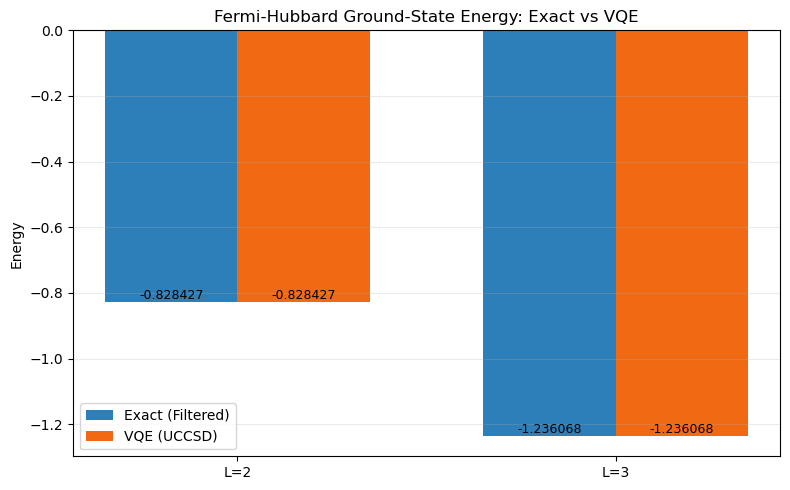

In [18]:
L_vals = [r['L'] for r in results]
exact_vals = [r['Exact_energy'] for r in results]
vqe_vals = [r['VQE_energy'] for r in results]

x = np.arange(len(L_vals))
width = 0.35
fig, ax = plt.subplots(figsize=(8, 5))
ax.bar(x - width/2, exact_vals, width, label='Exact (Filtered)', color='#2c7fb8')
ax.bar(x + width/2, vqe_vals, width, label='VQE (UCCSD)', color='#f16913')

ax.set_xticks(x)
ax.set_xticklabels([f'L={L}' for L in L_vals])
ax.set_ylabel('Energy')
ax.set_title('Fermi-Hubbard Ground-State Energy: Exact vs VQE')
ax.legend()
ax.grid(axis='y', alpha=0.25)

for i, (e_exact, e_vqe) in enumerate(zip(exact_vals, vqe_vals)):
    ax.text(i - width/2, e_exact, f'{e_exact:.6f}', ha='center', va='bottom', fontsize=9)
    ax.text(i + width/2, e_vqe, f'{e_vqe:.6f}', ha='center', va='bottom', fontsize=9)

plt.tight_layout()
if 'ipykernel' in sys.modules:
    plt.show()
else:
    out_png = 'Hubbard_VQE_Qiskit_energy_barplot.png'
    fig.savefig(out_png, dpi=160)
    print(f'Saved plot to {out_png}')


## Hamiltonian-Only Run: L=4 and L=5 (Periodic, Blocked)

This section uses Qiskit built-ins to generate JW Hamiltonians for `L=4` and `L=5`, writes JSON, and compares against `pydephasing/quantum/hubbard_jw_L4_L5_periodic_blocked.json`.


In [ ]:
import json
from pathlib import Path
from pprint import pprint

L45_CONFIG = {
    'lattice_sizes': [4, 5],
    'hopping_t': 1.0,
    'onsite_u': 4.0,
    'boundary_condition': 'periodic',
    'spin_orbital_ordering': 'blocked',
    'coefficient_tolerance': 1e-12,
}

def _periodic_edge_set(num_sites, t):
    lattice = LineLattice(
        num_nodes=num_sites,
        edge_parameter=-t,
        onsite_parameter=0.0,
        boundary_condition=BoundaryCondition.PERIODIC,
    )
    edges = set()
    for i, j, w in lattice.weighted_edge_list:
        if i == j:
            continue
        if abs(complex(w)) <= L45_CONFIG['coefficient_tolerance']:
            continue
        edges.add(tuple(sorted((int(i), int(j)))))
    return [list(e) for e in sorted(edges)]

def _real_pauli_dict(qubit_op, tol):
    terms = {}
    for label, coeff in qubit_op.to_list():
        c = complex(coeff)
        if abs(c) <= tol:
            continue
        if abs(c.imag) > tol:
            raise ValueError(f'Non-real coefficient for {label}: {c}')
        terms[label] = terms.get(label, 0.0) + float(c.real)
    terms = {k: v for k, v in terms.items() if abs(v) > tol}
    return {k: terms[k] for k in sorted(terms)}

def _balanced_spin_sectors(L):
    if L % 2 == 0:
        return [[L // 2, L // 2]]
    return [[L // 2, (L + 1) // 2], [(L + 1) // 2, L // 2]]

def _case_for_L(L):
    mapper = JordanWignerMapper()
    qubit_ham = build_qubit_hamiltonian(
        L,
        L45_CONFIG['hopping_t'],
        L45_CONFIG['onsite_u'],
        mapper,
        spin_orbital_ordering=L45_CONFIG['spin_orbital_ordering'],
    ).simplify(atol=L45_CONFIG['coefficient_tolerance'])

    terms = _real_pauli_dict(qubit_ham, L45_CONFIG['coefficient_tolerance'])

    return {
        'metadata': {
            'L': L,
            't': L45_CONFIG['hopping_t'],
            'U': L45_CONFIG['onsite_u'],
            'boundary_condition': L45_CONFIG['boundary_condition'],
            'coefficient_tolerance': L45_CONFIG['coefficient_tolerance'],
            'constant_shift_identity': float(terms.get('I' * (2 * L), 0.0)),
            'edge_set': _periodic_edge_set(L, L45_CONFIG['hopping_t']),
            'indexing': {
                'name': L45_CONFIG['spin_orbital_ordering'],
                'pauli_string_qubit_order': 'left_to_right = q_(n-1) ... q_0',
                'spin_orbital_order_before_jw': [
                    *[f'alpha{i}' for i in range(L)],
                    *[f'beta{i}' for i in range(L)],
                ],
            },
            'num_qubits': 2 * L,
            'num_pauli_terms': len(terms),
            'particle_sector': {
                'filling': 'half',
                'constraint': 'N_alpha + N_beta = L',
                'total_particles': L,
                'balanced_spin_sectors_for_comparison': _balanced_spin_sectors(L),
            },
        },
        'pauli_terms': terms,
    }

ham_l45_payload = {
    'description': '1D Fermi-Hubbard JW Hamiltonians',
    'parameters': {
        't': L45_CONFIG['hopping_t'],
        'U': L45_CONFIG['onsite_u'],
        'boundary_condition': L45_CONFIG['boundary_condition'],
        'indexing': L45_CONFIG['spin_orbital_ordering'],
        'coefficient_tolerance': L45_CONFIG['coefficient_tolerance'],
        'lattice_sizes': L45_CONFIG['lattice_sizes'],
    },
    'cases': {f"L={L}": _case_for_L(L) for L in L45_CONFIG['lattice_sizes']},
}

out_path_l45 = Path('Tests/hubbard_jw_L4_L5_periodic_blocked_qiskit.json')
out_path_l45.write_text(json.dumps(ham_l45_payload, indent=2))
print(f'Wrote {out_path_l45}')

for L in L45_CONFIG['lattice_sizes']:
    case = ham_l45_payload['cases'][f'L={L}']
    print(f"L={L} | num_qubits={case['metadata']['num_qubits']} | num_terms={case['metadata']['num_pauli_terms']}")
    pprint(case['pauli_terms'])


In [ ]:
from math import isclose

ref_path_l45 = Path('pydephasing/quantum/hubbard_jw_L4_L5_periodic_blocked.json')
ref_l45 = json.loads(ref_path_l45.read_text())

for L in L45_CONFIG['lattice_sizes']:
    ours = ham_l45_payload['cases'][f'L={L}']['pauli_terms']
    ref = ref_l45['cases'][f'L={L}']['pauli_terms']
    all_terms = sorted(set(ours) | set(ref))
    diffs = []
    for term in all_terms:
        ov = float(ours.get(term, 0.0))
        rv = float(ref.get(term, 0.0))
        if not isclose(ov, rv, abs_tol=L45_CONFIG['coefficient_tolerance'], rel_tol=0.0):
            diffs.append((term, ov, rv, ov - rv))

    print(f'Comparison L={L}: ours={len(ours)} terms, ref={len(ref)} terms, diffs={len(diffs)}')
    if diffs:
        print('  sample diffs:', diffs[:8])
    else:
        print('  exact term-by-term match')


## Notes
- `Exact_energy` is filtered to the same `(N_alpha, N_beta)` particle sector as UCCSD/HartreeFock.
- This notebook is fully standalone and does not import any files from this repo.
